In [1]:
!pip install -q transformers==4.24.0

!pip install -q gradio
!sudo apt-get install git-lfs
!git lfs install

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cached-path 1.1.3 requires huggingface-hub<0.8.0,>=0.0.12, but you have huggingface-hub 0.16.4 which is incompatible.
allennlp 2.9.3 requires transformers<4.19,>=4.1, but you have transformers 4.24.0 which is incompatible.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 3316 kB of archives.
After this operation, 11.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 git-lfs amd64 2.9.2-1 [3316 kB]
Fetched 3316 kB in 5s (690 kB/s)    
Selecting previously unselected package git-lfs.
(Reading database ... 108264 files and directories currently installed.)
Preparing to unpack .../git-lfs_2

In [ ]:
# !wandb login --relogin

In [2]:
import os
#import wandb
import torch
import pickle
import numpy as np
%matplotlib inline
import pandas as pd
import gradio as gr
import seaborn as sns
import tensorflow as tf
from typing import Dict
from ast import literal_eval
from torch.optim import AdamW
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from kaggle_secrets import UserSecretsClient
from torch.nn import BCEWithLogitsLoss, BCELoss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from transformers import XLNetForSequenceClassification, XLNetTokenizer,BertForSequenceClassification,BertTokenizer, RobertaForSequenceClassification,RobertaTokenizer

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [4]:
torch.__version__

'1.11.0'

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'


> I will be integrating W&B for visualizations and logging artifacts and comparisons of different models!

> 
> - To get the API key, create an account in the [website](https://wandb.ai/site) .
> - Use secrets to use API Keys more securely 

In [7]:
# try:
#     from kaggle_secrets import UserSecretsClient
#     user_secrets = UserSecretsClient()
#     secret_value_0 = user_secrets.get_secret("wandb_api")
#     wandb.login(key=secret_value_0)
#     anony=None
# except:
#     anony = "must"
#     print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    
# wandb.init(project="BioBert Algorithm - Medical Dataset",name=f"BioBert Algorithm - Medical Dataset")

# ***Reading Processed Dataset***

In [8]:
import pandas as pd
train_dataset = pd.read_csv('/kaggle/input/masterproject-medicaldataset/TrainPreProcessed_Data.csv')
df = pd.DataFrame(train_dataset)
test_dataset = pd.read_csv('/kaggle/input/masterproject-medicaldataset/TestPreProcessed_Data.csv')
test_df = pd.DataFrame(test_dataset)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11550 entries, 0 to 11549
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   condition_label      11550 non-null  object
 1   medical_abstract     11550 non-null  object
 2   medical_abstract_lw  11550 non-null  object
 3   medical_abstract_cl  11550 non-null  object
 4   medical_abstract_lm  11550 non-null  object
 5   medical_abstract_sw  11550 non-null  object
dtypes: object(6)
memory usage: 541.5+ KB


In [10]:
print("Total number of Articles extracted from Bioasq dataset are =",len(df))

Total number of Articles extracted from Bioasq dataset are = 11550


In [11]:
print('Average Article length: ', df.medical_abstract.str.split().str.len().mean())
print('Stdev Article length: ', df.medical_abstract.str.split().str.len().std())

Average Article length:  179.64060606060605
Stdev Article length:  76.3697757005607


In [12]:
df = pd.get_dummies(df, columns=['condition_label', ])
df

,medical_abstract,medical_abstract_lw,medical_abstract_cl,medical_abstract_lm,medical_abstract_sw,condition_label_Cardiovascular diseases,condition_label_Digestive system diseases,condition_label_General pathological conditions,condition_label_Neoplasms,condition_label_Nervous system diseases
0,Tissue changes around loose prostheses. A cani...,tissue changes around loose prostheses. a cani...,tissue changes around loose prostheses canine ...,tissue changes around loose prostheses canine ...,tissue changes around loose prostheses canine ...,0,0,1,0,0
1,Neuropeptide Y and neuron-specific enolase lev...,neuropeptide y and neuron-specific enolase lev...,neuropeptide neuronspecific enolase levels ben...,neuropeptide neuronspecific enolase levels ben...,neuropeptide neuronspecific enolase levels ben...,0,0,0,1,0
2,"Sexually transmitted diseases of the colon, re...","sexually transmitted diseases of the colon, re...",sexually transmitted diseases colon rectum anu...,sexually transmitted diseases colon rectum anu...,sexually transmitted diseases colon rectum anu...,0,1,0,0,0
3,Lipolytic factors associated with murine and h...,lipolytic factors associated with murine and h...,lipolytic factors associated murine human canc...,lipolytic factors associated murine human canc...,lipolytic factors associated murine human canc...,0,0,0,1,0
4,Does carotid restenosis predict an increased r...,does carotid restenosis predict an increased r...,carotid restenosis predict increased risk late...,carotid restenosis predict increased risk late...,carotid restenosis predict increased risk late...,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
11545,Epirubicin at two dose levels with prednisolon...,epirubicin at two dose levels with prednisolon...,epirubicin two dose levels prednisolone treatm...,epirubicin two dose levels prednisolone treatm...,epirubicin two dose levels prednisolone treatm...,0,0,0,1,0
11546,Four and a half year follow up of women with d...,four and a half year follow up of women with d...,four half year follow women dyskaryotic cervic...,four half year follow women dyskaryotic cervic...,four half year follow women dyskaryotic cervic...,0,0,0,1,0
11547,Safety of the transbronchial biopsy in outpati...,safety of the transbronchial biopsy in outpati...,safety transbronchial biopsy outpatients objec...,safety transbronchial biopsy outpatients objec...,safety transbronchial biopsy outpatients objec...,0,0,1,0,0
11548,Interictal spikes and hippocampal somatostatin...,interictal spikes and hippocampal somatostatin...,interictal spikes hippocampal somatostatin lev...,interictal spikes hippocampal somatostatin lev...,interictal spikes hippocampal somatostatin lev...,0,0,0,0,1


In [13]:
cols = df.columns
cols = list(df.columns)
condition_labels = cols[5:]
num_labels = len(condition_labels)
print('Condition labels Class: "\n"',condition_labels)
print("\n")
print('Number of Labels: ' ,num_labels)

Condition labels Class: "
" ['condition_label_Cardiovascular diseases', 'condition_label_Digestive system diseases', 'condition_label_General pathological conditions', 'condition_label_Neoplasms', 'condition_label_Nervous system diseases']


Number of Labels:  5


In [14]:
%%time

counts = []
for condition_label in condition_labels:
    counts.append((condition_label, df[condition_label].sum()))
df_count = pd.DataFrame(counts, columns=['Condition Label', 'number of Abstract'])
df_count

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.96 ms


,Condition Label,number of Abstract
0,condition_label_Cardiovascular diseases,2441
1,condition_label_Digestive system diseases,1195
2,condition_label_General pathological conditions,3844
3,condition_label_Neoplasms,2530
4,condition_label_Nervous system diseases,1540


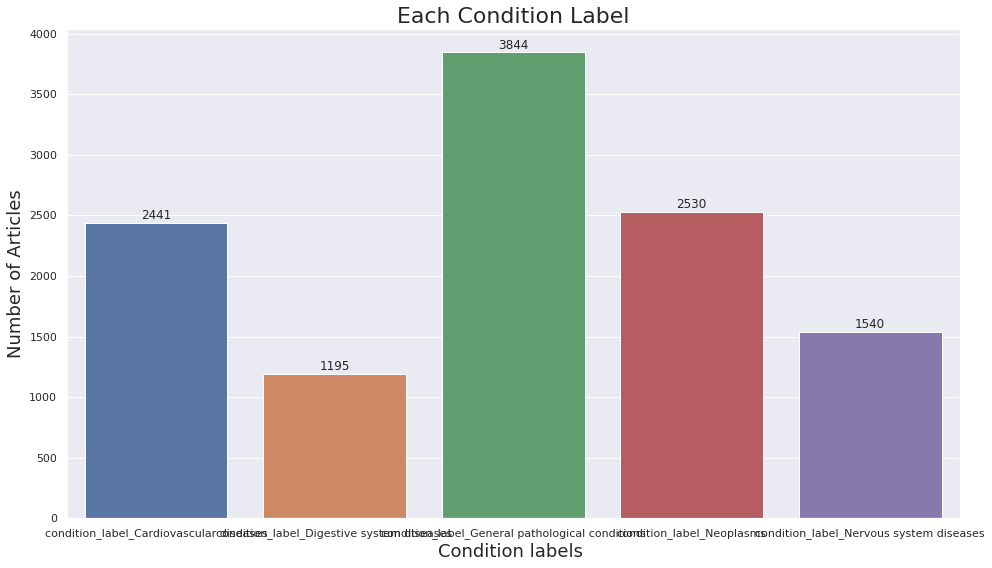

CPU times: user 446 ms, sys: 262 ms, total: 708 ms
Wall time: 319 ms


In [15]:
%%time
sns.set(font_scale = 1)
plt.figure(figsize=(16,9))
ax= sns.barplot(condition_labels, df.iloc[:,5:].sum().values)
plt.title("Each Condition Label", fontsize=22)
plt.ylabel('Number of Articles', fontsize=18)
plt.xlabel('Condition labels ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = df.iloc[:,5:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)

plt.show()

In [16]:
# df_train, df_test = train_test_split(df, random_state=32, test_size=0.20, shuffle=True)

# print(df_train.shape)
# print(df_test.shape)

In [17]:
df['one_hot_labels'] = list(df[condition_labels].values)
df.shape

(11550, 11)

In [18]:
df

,medical_abstract,medical_abstract_lw,medical_abstract_cl,medical_abstract_lm,medical_abstract_sw,condition_label_Cardiovascular diseases,condition_label_Digestive system diseases,condition_label_General pathological conditions,condition_label_Neoplasms,condition_label_Nervous system diseases,one_hot_labels
0,Tissue changes around loose prostheses. A cani...,tissue changes around loose prostheses. a cani...,tissue changes around loose prostheses canine ...,tissue changes around loose prostheses canine ...,tissue changes around loose prostheses canine ...,0,0,1,0,0,"[0, 0, 1, 0, 0]"
1,Neuropeptide Y and neuron-specific enolase lev...,neuropeptide y and neuron-specific enolase lev...,neuropeptide neuronspecific enolase levels ben...,neuropeptide neuronspecific enolase levels ben...,neuropeptide neuronspecific enolase levels ben...,0,0,0,1,0,"[0, 0, 0, 1, 0]"
2,"Sexually transmitted diseases of the colon, re...","sexually transmitted diseases of the colon, re...",sexually transmitted diseases colon rectum anu...,sexually transmitted diseases colon rectum anu...,sexually transmitted diseases colon rectum anu...,0,1,0,0,0,"[0, 1, 0, 0, 0]"
3,Lipolytic factors associated with murine and h...,lipolytic factors associated with murine and h...,lipolytic factors associated murine human canc...,lipolytic factors associated murine human canc...,lipolytic factors associated murine human canc...,0,0,0,1,0,"[0, 0, 0, 1, 0]"
4,Does carotid restenosis predict an increased r...,does carotid restenosis predict an increased r...,carotid restenosis predict increased risk late...,carotid restenosis predict increased risk late...,carotid restenosis predict increased risk late...,0,0,0,0,1,"[0, 0, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...,...,...
11545,Epirubicin at two dose levels with prednisolon...,epirubicin at two dose levels with prednisolon...,epirubicin two dose levels prednisolone treatm...,epirubicin two dose levels prednisolone treatm...,epirubicin two dose levels prednisolone treatm...,0,0,0,1,0,"[0, 0, 0, 1, 0]"
11546,Four and a half year follow up of women with d...,four and a half year follow up of women with d...,four half year follow women dyskaryotic cervic...,four half year follow women dyskaryotic cervic...,four half year follow women dyskaryotic cervic...,0,0,0,1,0,"[0, 0, 0, 1, 0]"
11547,Safety of the transbronchial biopsy in outpati...,safety of the transbronchial biopsy in outpati...,safety transbronchial biopsy outpatients objec...,safety transbronchial biopsy outpatients objec...,safety transbronchial biopsy outpatients objec...,0,0,1,0,0,"[0, 0, 1, 0, 0]"
11548,Interictal spikes and hippocampal somatostatin...,interictal spikes and hippocampal somatostatin...,interictal spikes hippocampal somatostatin lev...,interictal spikes hippocampal somatostatin lev...,interictal spikes hippocampal somatostatin lev...,0,0,0,0,1,"[0, 0, 0, 0, 1]"


In [19]:
labels = list(df.one_hot_labels.values)
Article_train = list(df.medical_abstract_sw.values)

# ***Tokenizations***

In [20]:
max_length = 128
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2', do_lower_case=True) 

encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [24]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow me to stratify split our training data later
label_counts = df.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  []


In [25]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.20)

# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

# ***Creating the Data Loaders***

In [26]:
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [27]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

# ***Loading the pretrained model***

In [29]:
# import torch

# # Define the device based on CUDA availability
# device = torch.device("cpu" if torch.cuda.is_available() else None)
# print("Using device:", device)

In [28]:
%%time
model = BertForSequenceClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2", num_labels=num_labels)
model.cuda()
print('Model Pushed to Cuda for Training')

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

Model Pushed to Cuda for Training
CPU times: user 1.82 s, sys: 1.03 s, total: 2.85 s
Wall time: 4.14 s


In [30]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [31]:
optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)

In [32]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

# ***Training the model***

In [33]:
%%time

# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_score_list,val_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

# Number of training epochs (recommend between 5 and 10)
epochs = 5

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch "):
    # Training
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()
    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels= batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # Forward pass for multilabel classification
        # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html
        # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
        # Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities
        # Also This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable 
        # than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the 
        # log-sum-exp trick for numerical stability.
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss()  
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    training_loss_list.append(tr_loss/nb_tr_steps)

    ###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_score = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100
    val_precision_score = precision_score(true_bools, pred_bools,average='micro')*100
    val_recall_score = recall_score(true_bools, pred_bools,average='micro')*100

    print('Validation Accuracy: ', val_flat_accuracy)
    print('Validation Precision: ', val_precision_score)
    print('Validation Recall: ', val_recall_score)
    print('Validation F1 Score: ', val_f1_score)
    print('\n')
    val_f1_score_list.append(val_f1_score)
    val_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)  
    
#     wandb.log({"train_loss":tr_loss/nb_tr_steps,"val_f1_score":val_f1_score,"val_flat_accuracy":val_flat_accuracy,"val_recall_score":val_recall_score,"val_precision_score":val_precision_score})
# wandb.finish()

Epoch :   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.46301793414970926


Epoch :  20%|██        | 1/5 [01:47<07:11, 107.94s/it]

Validation Accuracy:  16.666666666666664
Validation Precision:  100.0
Validation Recall:  16.666666666666664
Validation F1 Score:  28.57142857142857


Train loss: 0.34235404565416533


Epoch :  40%|████      | 2/5 [03:35<05:22, 107.43s/it]

Validation Accuracy:  83.33333333333334
Validation Precision:  83.33333333333334
Validation Recall:  83.33333333333334
Validation F1 Score:  83.33333333333334


Train loss: 0.30425175202303917


Epoch :  60%|██████    | 3/5 [05:22<03:34, 107.26s/it]

Validation Accuracy:  66.66666666666666
Validation Precision:  80.0
Validation Recall:  66.66666666666666
Validation F1 Score:  72.72727272727272


Train loss: 0.2838168420668306


Epoch :  80%|████████  | 4/5 [07:09<01:47, 107.20s/it]

Validation Accuracy:  66.66666666666666
Validation Precision:  66.66666666666666
Validation Recall:  66.66666666666666
Validation F1 Score:  66.66666666666666


Train loss: 0.2679879669485421


Epoch : 100%|██████████| 5/5 [08:56<00:00, 107.27s/it]

Validation Accuracy:  66.66666666666666
Validation Precision:  66.66666666666666
Validation Recall:  66.66666666666666
Validation F1 Score:  66.66666666666666


CPU times: user 8min 55s, sys: 690 ms, total: 8min 55s
Wall time: 8min 56s


In [36]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_results=pd.DataFrame({'Epochs':num_epochs,'F1 Score Validation':val_f1_score_list,'Validation Accuracy':val_accuracy_list,'Train loss':training_loss_list})

In [37]:
df_results

,Epochs,F1 Score Validation,Validation Accuracy,Train loss
0,1,28.571429,16.666667,0.463018
1,2,83.333333,83.333333,0.342354
2,3,72.727273,66.666667,0.304252
3,4,66.666667,66.666667,0.283817
4,5,66.666667,66.666667,0.267988


# ***Visualizing The results***

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for Bert-Base')

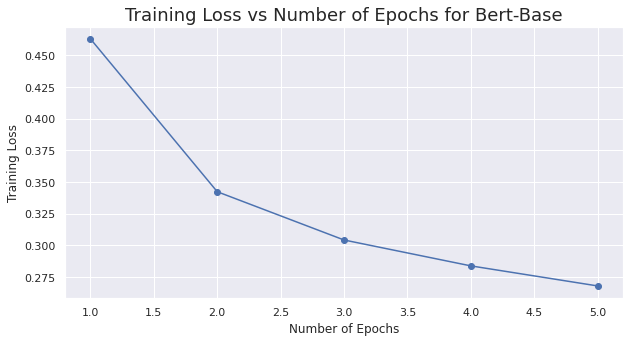

In [38]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Bert-Base",fontsize=18)

(0.0, 100.0)

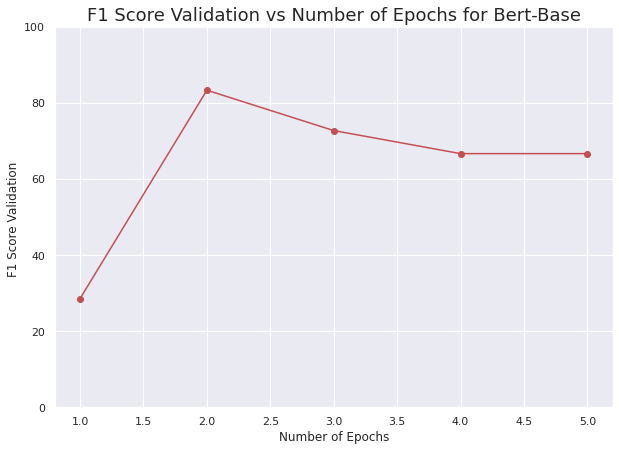

In [39]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_score_list),'ro-' ,label="F1 Score Validation")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Score Validation ")
ax.set_title("F1 Score Validation vs Number of Epochs for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

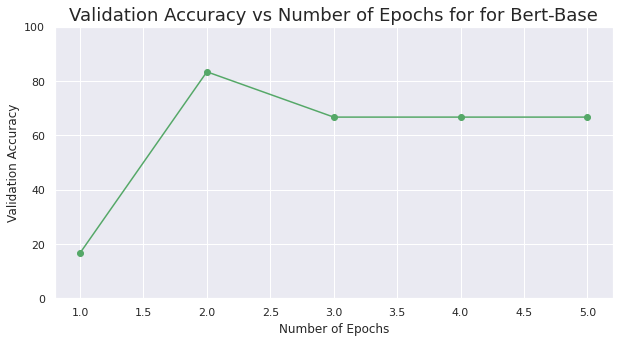

In [40]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_accuracy_list),'go-', label="Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Validation Accuracy")
ax.set_title("Validation Accuracy vs Number of Epochs for for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

# **Evaluating the model on test_df and Classification Report**

In [41]:
test_df

,condition_label,medical_abstract,medical_abstract_lw,medical_abstract_cl,medical_abstract_lm,medical_abstract_sw
0,Nervous system diseases,Obstructive sleep apnea following topical orop...,obstructive sleep apnea following topical orop...,obstructive sleep apnea following topical orop...,obstructive sleep apnea following topical orop...,obstructive sleep apnea following topical orop...
1,General pathological conditions,Neutrophil function and pyogenic infections in...,neutrophil function and pyogenic infections in...,neutrophil function pyogenic infections bone m...,neutrophil function pyogenic infections bone m...,neutrophil function pyogenic infections bone m...
2,General pathological conditions,A phase II study of combined methotrexate and ...,a phase ii study of combined methotrexate and ...,phase ii study combined methotrexate teniposid...,phase ii study combined methotrexate teniposid...,phase ii study combined methotrexate teniposid...
3,Neoplasms,Flow cytometric DNA analysis of parathyroid tu...,flow cytometric dna analysis of parathyroid tu...,flow cytometric dna analysis parathyroid tumor...,flow cytometric dna analysis parathyroid tumor...,flow cytometric dna analysis parathyroid tumor...
4,Cardiovascular diseases,Paraneoplastic vasculitic neuropathy: a treata...,paraneoplastic vasculitic neuropathy: a treata...,paraneoplastic vasculitic neuropathy treatable...,paraneoplastic vasculitic neuropathy treatable...,paraneoplastic vasculitic neuropathy treatable...
...,...,...,...,...,...,...
2883,Cardiovascular diseases,Management of aortobronchial fistula with graf...,management of aortobronchial fistula with graf...,management aortobronchial fistula graft replac...,management aortobronchial fistula graft replac...,management aortobronchial fistula graft replac...
2884,General pathological conditions,Tuberculous psoas muscle abscess following che...,tuberculous psoas muscle abscess following che...,tuberculous psoas muscle abscess following che...,tuberculous psoas muscle abscess following che...,tuberculous psoas muscle abscess following che...
2885,Cardiovascular diseases,Clinical evaluation of high-frequency (ultraso...,clinical evaluation of high-frequency (ultraso...,clinical evaluation highfrequency ultrasonic m...,clinical evaluation highfrequency ultrasonic m...,clinical evaluation highfrequency ultrasonic m...
2886,Neoplasms,Antitumor activity of liposome-encapsulated do...,antitumor activity of liposome-encapsulated do...,antitumor activity liposomeencapsulated doxoru...,antitumor activity liposomeencapsulated doxoru...,antitumor activity liposomeencapsulated doxoru...


In [42]:
test_df = pd.get_dummies(test_df, columns=['condition_label', ])
test_df

,medical_abstract,medical_abstract_lw,medical_abstract_cl,medical_abstract_lm,medical_abstract_sw,condition_label_Cardiovascular diseases,condition_label_Digestive system diseases,condition_label_General pathological conditions,condition_label_Neoplasms,condition_label_Nervous system diseases
0,Obstructive sleep apnea following topical orop...,obstructive sleep apnea following topical orop...,obstructive sleep apnea following topical orop...,obstructive sleep apnea following topical orop...,obstructive sleep apnea following topical orop...,0,0,0,0,1
1,Neutrophil function and pyogenic infections in...,neutrophil function and pyogenic infections in...,neutrophil function pyogenic infections bone m...,neutrophil function pyogenic infections bone m...,neutrophil function pyogenic infections bone m...,0,0,1,0,0
2,A phase II study of combined methotrexate and ...,a phase ii study of combined methotrexate and ...,phase ii study combined methotrexate teniposid...,phase ii study combined methotrexate teniposid...,phase ii study combined methotrexate teniposid...,0,0,1,0,0
3,Flow cytometric DNA analysis of parathyroid tu...,flow cytometric dna analysis of parathyroid tu...,flow cytometric dna analysis parathyroid tumor...,flow cytometric dna analysis parathyroid tumor...,flow cytometric dna analysis parathyroid tumor...,0,0,0,1,0
4,Paraneoplastic vasculitic neuropathy: a treata...,paraneoplastic vasculitic neuropathy: a treata...,paraneoplastic vasculitic neuropathy treatable...,paraneoplastic vasculitic neuropathy treatable...,paraneoplastic vasculitic neuropathy treatable...,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2883,Management of aortobronchial fistula with graf...,management of aortobronchial fistula with graf...,management aortobronchial fistula graft replac...,management aortobronchial fistula graft replac...,management aortobronchial fistula graft replac...,1,0,0,0,0
2884,Tuberculous psoas muscle abscess following che...,tuberculous psoas muscle abscess following che...,tuberculous psoas muscle abscess following che...,tuberculous psoas muscle abscess following che...,tuberculous psoas muscle abscess following che...,0,0,1,0,0
2885,Clinical evaluation of high-frequency (ultraso...,clinical evaluation of high-frequency (ultraso...,clinical evaluation highfrequency ultrasonic m...,clinical evaluation highfrequency ultrasonic m...,clinical evaluation highfrequency ultrasonic m...,1,0,0,0,0
2886,Antitumor activity of liposome-encapsulated do...,antitumor activity of liposome-encapsulated do...,antitumor activity liposomeencapsulated doxoru...,antitumor activity liposomeencapsulated doxoru...,antitumor activity liposomeencapsulated doxoru...,0,0,0,1,0


In [43]:
test_df['one_hot_labels'] = list(test_df[condition_labels].values)
test_df.head(3)

,medical_abstract,medical_abstract_lw,medical_abstract_cl,medical_abstract_lm,medical_abstract_sw,condition_label_Cardiovascular diseases,condition_label_Digestive system diseases,condition_label_General pathological conditions,condition_label_Neoplasms,condition_label_Nervous system diseases,one_hot_labels
0,Obstructive sleep apnea following topical orop...,obstructive sleep apnea following topical orop...,obstructive sleep apnea following topical orop...,obstructive sleep apnea following topical orop...,obstructive sleep apnea following topical orop...,0,0,0,0,1,"[0, 0, 0, 0, 1]"
1,Neutrophil function and pyogenic infections in...,neutrophil function and pyogenic infections in...,neutrophil function pyogenic infections bone m...,neutrophil function pyogenic infections bone m...,neutrophil function pyogenic infections bone m...,0,0,1,0,0,"[0, 0, 1, 0, 0]"
2,A phase II study of combined methotrexate and ...,a phase ii study of combined methotrexate and ...,phase ii study combined methotrexate teniposid...,phase ii study combined methotrexate teniposid...,phase ii study combined methotrexate teniposid...,0,0,1,0,0,"[0, 0, 1, 0, 0]"


In [44]:
test_labels = list(test_df.one_hot_labels.values)
Articles_test = list(test_df.medical_abstract_sw.values)
test_condition_labels = list(test_df.columns[5:10])

In [45]:
test_condition_labels

['condition_label_Cardiovascular diseases',
 'condition_label_Digestive system diseases',
 'condition_label_General pathological conditions',
 'condition_label_Neoplasms',
 'condition_label_Nervous system diseases']

In [46]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [47]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

In [48]:
%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 10 s, sys: 8.97 ms, total: 10 s
Wall time: 10 s


In [49]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Score=f1_score(true_bools, pred_bools,average='micro')*100
Test_Accuracy= accuracy_score(true_bools, pred_bools)*100
Test_precision_score = precision_score(true_bools, pred_bools,average='micro')*100
Test_recall_score = recall_score(true_bools, pred_bools,average='micro')*100

print('Test F1 Score: ',Test_F1_Score )
print('Test Accuracy: ',Test_Accuracy)
print('Test Precision Score: ',Test_precision_score)
print('Test Recall Score: ',Test_recall_score)

#df_test=pd.DataFrame({'Test F1 Score':Test_F1_Score, 'Test Accuracy':Test_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_condition_labels))
clf_report = classification_report(true_bools,pred_bools,target_names=test_condition_labels,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()

Test F1 Score:  63.76811594202898
Test Accuracy:  60.041551246537395
Test Precision Score:  66.8693009118541
Test Recall Score:  60.94182825484764
                                                 precision    recall  f1-score   support

        condition_label_Cardiovascular diseases       0.67      0.80      0.73       610
      condition_label_Digestive system diseases       0.59      0.66      0.62       299
condition_label_General pathological conditions       0.65      0.39      0.49       961
                      condition_label_Neoplasms       0.73      0.77      0.75       633
        condition_label_Nervous system diseases       0.66      0.57      0.61       385

                                      micro avg       0.67      0.61      0.64      2888
                                      macro avg       0.66      0.64      0.64      2888
                                   weighted avg       0.67      0.61      0.63      2888
                                    samples avg   

In [50]:
df_report.to_csv('Classification_Report.csv',index=False)

# **Uploadind the model on Hugging Face**

In [51]:
model.save_pretrained('./MP_Biobert_Classification_Save/')
tokenizer.save_pretrained('./MP_Biobert_Classification_Save/')

('./MP_Biobert_Classification_Save/tokenizer_config.json',
 './MP_Biobert_Classification_Save/special_tokens_map.json',
 './MP_Biobert_Classification_Save/vocab.txt',
 './MP_Biobert_Classification_Save/added_tokens.json')

In [52]:
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("MP_Biobert") ##Has kept it private. Please use your own token

In [53]:
#Converting Labels to categorical before pushing it to Hugging Face Hub
model.config.label2id= {
"Neoplasms": 0,
"Digestive System Diseases": 1,
"Nervous System Diseases": 2,
"Cardiovascular Diseases": 3,
"General Pathological Conditions": 4,
}


model.config.id2label={
    "0": "Neoplasms",
    "1": "Digestive System Diseases",
    "2": "Nervous System Diseases",
    "3": "Cardiovascular Diseases",
    "4": "General Pathological Conditions"
}
    

In [54]:
model.push_to_hub(repo_id='Nidhi0411/Medical-Abstracts-TC-Corpus-BioBert',use_auth_token=secret_value_0)

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Nidhi0411/Medical-Abstracts-TC-Corpus-BioBert/commit/e6159d9e07b777afcd902e631e42a5b847c8b09c', commit_message='Upload BertForSequenceClassification', commit_description='', oid='e6159d9e07b777afcd902e631e42a5b847c8b09c', pr_url=None, pr_revision=None, pr_num=None)

In [55]:
tokenizer.push_to_hub(repo_id='Nidhi0411/Medical-Abstracts-TC-Corpus-BioBert',use_auth_token=secret_value_0)

CommitInfo(commit_url='https://huggingface.co/Nidhi0411/Medical-Abstracts-TC-Corpus-BioBert/commit/cc641db23935d85c18afe9d28cf0010bb0f07e70', commit_message='Upload tokenizer', commit_description='', oid='cc641db23935d85c18afe9d28cf0010bb0f07e70', pr_url=None, pr_revision=None, pr_num=None)

In [56]:
tokenizer = BertTokenizer.from_pretrained('Nidhi0411/Medical-Abstracts-TC-Corpus-BioBert', do_lower_case=True) 

In [57]:
num_labels=5
model = BertForSequenceClassification.from_pretrained("Nidhi0411/Medical-Abstracts-TC-Corpus-BioBert", num_labels=5)

# **XAI: Shap and LIME**

In [59]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

In [60]:
import torch

# Define the device based on CUDA availability
device = torch.device("cpu" if torch.cuda.is_available() else None)
print("Using device:", device)

Using device: cpu


In [62]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("Nidhi0411/Medical-Abstracts-TC-Corpus-BioBert")
model = AutoModelForSequenceClassification.from_pretrained("Nidhi0411/Medical-Abstracts-TC-Corpus-BioBert")

In [63]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer)

In [68]:
!pip install shap

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [69]:
import shap
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

  0%|          | 0/210 [00:00<?, ?it/s]

Partition explainer: 2it [00:25, 25.56s/it]               


In [94]:
text = ["Modification of atrioventricular node transmission properties by intraoperative neodymium-YAG laser photocoagulation in dogs"]
res = classifier(text)
print(res)

[{'label': 'Neoplasms', 'score': 0.5804489850997925}]


In [91]:
# Get SHAP values
explainer = shap.Explainer(classifier)
shap_values = explainer(text)
shap.plots.text(shap_values[0])

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 2it [00:36, 36.44s/it]               


In [76]:
import numpy as np
import lime
import torch
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

class_names =["Neoplasms", "Digestive system","Nervous system", "Cardiovascular", "General Pathological Conditions"]

def predictor(texts):
    outputs = model(**tokenizer(texts, return_tensors="pt", padding=True))
    tensor_logits = outputs[0]
    probas = F.softmax(tensor_logits).detach().numpy()
    return probas

In [78]:
# text = "how cold is it outside today"
text="Absorption and motility of the bypassed human ileum."
# text="play the [song_name : weekend]"
print(tokenizer(text, return_tensors='pt', padding=True))

explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text, predictor, num_features=5, num_samples=100)
exp.show_in_notebook(text=text)

{'input_ids': tensor([[  101, 18099,  1105,   182,  3329, 13378,  1104,  1103, 13981,  1174,
          1769, 14596, 14136,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
